In [1]:
import numpy as np
import pandas as pd

import math
from random import shuffle
import random
random.seed(0)

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression

givenDec = lambda gdVal: float('%.1f' % gdVal) # 1 digit
givenDec3 = lambda gdVal: float('%.3f' % gdVal) # 3 digit

### Classification

In [2]:
# function to generate data points for family car example
def generateCarTypeData(gnPoints):
    
    engine_power_all = []
    price_all = []
    famCar_class = []

    for i in range(gnPoints):
        rnd_val = np.random.random()
        rnd_val_e = np.random.random()
        rnd_val_p = np.random.random()
        if(rnd_val < 0.5):
            famCar_class.append(0)
            tmp_eng_power = np.random.randint(low=50, high=240)
            tmp_price = np.random.randint(low=10, high=100)

            while (120<tmp_eng_power<180 and 25<tmp_price<50):
                tmp_eng_power = np.random.randint(low=50, high=240)
                tmp_price = np.random.randint(low=10, high=100)

            engine_power_all.append(tmp_eng_power)
            price_all.append(tmp_price)
        else:
            famCar_class.append(1)
            engine_power_all.append(np.random.randint(low=120, high=180))
            price_all.append(np.random.randint(low=25, high=50))

    tmp_df = pd.DataFrame({
        "e":engine_power_all,
        "p":price_all,
        "c":famCar_class
    })
    
    return tmp_df


In [3]:
my_df = generateCarTypeData(gnPoints=40)
#my_df

A scatter plot of data points

<AxesSubplot: xlabel='e', ylabel='p'>

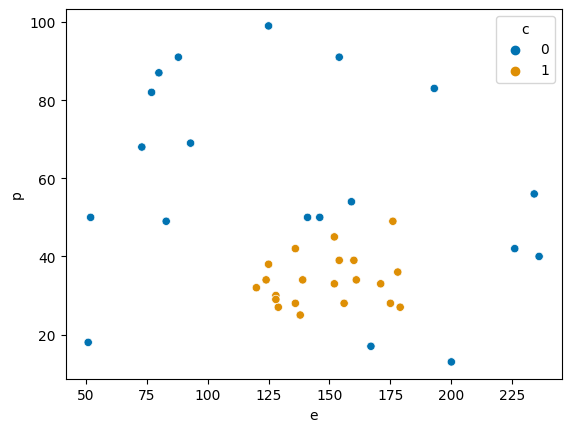

In [4]:
#plt.scatter(my_df.e, my_df.p, marker='o');
sns.scatterplot(x="e", y="p", hue="c", data=my_df, palette="colorblind")

In [5]:
# get the min price of a family car from the data set my_df
my_df[my_df['c']==1]['p'].min()

25

In [13]:
# get the max price of a NON-family car that is smaller than minimum price of a family car
min_price = my_df[my_df['c']==1]['p'].min()
my_df[(my_df['c']==0) & (my_df['p'] < min_price)]['p'].max()

18

$\color{red}{\text{Hint:}}$ Implement a function that returns min/max price/engine power values that define a rectangle classifier

In [6]:
# from 2D data, get the range values associated with a family car
def getRange_familyCar(gdf):
    min_price = gdf[gdf['c']==1]['p'].min()
    max_price = gdf[gdf['c']==1]['p'].max()
    min_engine = gdf[gdf['c']==1]['e'].min()
    max_engine = gdf[gdf['c']==1]['e'].max()
    
    return min_price, max_price, min_engine, max_engine
    

In [10]:
getRange_familyCar(my_df)

(25, 49, 120, 179)

$\color{red}{\text{Question:}}$ Implement a function that returns min/max price/engine power values that define the LARGEST rectangle classifier

In [25]:
def getRange_familyCar_large(gdf):
    min_price_s, max_price_s, min_engine_s, max_engine_s = getRange_familyCar(gdf)  
    min_price = my_df[(my_df['c']==0) & (my_df['p'] < min_price_s)]['p'].max()
    max_price = my_df[(my_df['c']==0) & (my_df['p'] > max_price_s)]['p'].min()
    min_engine = my_df[(my_df['c']==0) & (my_df['e'] < min_engine_s)]['e'].max()
    max_engine = my_df[(my_df['c']==0) & (my_df['e'] > max_engine_s)]['e'].min()
    
    
    return min_price, max_price, min_engine, max_engine


In [26]:
getRange_familyCar_large(my_df)

(18, 50, 93, 193)

$\color{red}{\text{Question:}}$ Implement a function that returns min/max price/engine power values that define a medium (between smallest and largest) rectangle classifier

In [29]:
def getRange_familyCar_medium(gdf):
    # we can define any h between S and G. we are taking the mean
    min_price_s, max_price_s, min_engine_s, max_engine_s = getRange_familyCar(gdf)
    min_price_l, max_price_l, min_engine_l, max_engine_l = getRange_familyCar_large(gdf)
    min_price = (min_price_s + min_price_l)/2
    max_price = (max_price_s + max_price_l)/2
    min_engine = (min_engine_s + min_engine_l)/2
    max_engine = (max_engine_s + max_engine_l)/2
    
    return min_price, max_price, min_engine, max_engine

In [30]:
getRange_familyCar_medium(my_df)

(21.5, 49.5, 106.5, 186.0)

In [31]:
min_p, max_p, min_e, max_e = getRange_familyCar(my_df)
print("rectangle",min_p, max_p, min_e, max_e)

min_p, max_p, min_e, max_e = getRange_familyCar_large(my_df)
print("rectangle",min_p, max_p, min_e, max_e)

min_p, max_p, min_e, max_e = getRange_familyCar_medium(my_df)
print("rectangle",min_p, max_p, min_e, max_e)

rectangle 25 49 120 179
rectangle 18 50 93 193
rectangle 21.5 49.5 106.5 186.0


In [32]:
def classify_instance_byRectangle(min_price, max_price, min_engine, max_engine, gdf_instance):
    if(min_engine<gdf_instance.e<max_engine and min_price<gdf_instance.p<max_price):
        return 1
    else:
        return 0

In [33]:
# first row of the data set
my_df.iloc[0]

e    136
p     28
c      1
Name: 0, dtype: int64

In [34]:
classify_instance_byRectangle(25, 46, 120, 179, my_df.iloc[0])

1

$\color{red}{\text{Question:}}$ Implement a function that classifies a given data point using a circle classifier (obtained through data points that encapsulate family cars in the data set)

In [61]:
def classify_instance_byCircle(min_price, max_price, min_engine, max_engine, gdf_instance):
    center_price, center_engine = (max_price + min_price)/2,  (min_engine + max_engine)/2
    radius = max_price - center_price
    if (gdf_instance.p - center_price)**2 + (gdf_instance.e - center_engine)**2 <= radius**2 :
        return 1
    else:
        return 0

In [62]:
classify_instance_byCircle(25, 46, 120, 179, my_df.iloc[0])

0

In [63]:
classify_instance_byCircle(21.5, 49.5, 106.5, 186.0, my_df.iloc[0])

1

$\color{red}{\text{Question:}}$ Implement a function that classifies a given data point using a ellipsoid classifier (obtained through data points that encapsulate family cars in the data set)

In [65]:
def classify_instance_byEllipsoid(min_price, max_price, min_engine, max_engine, gdf_instance):
    center_price, center_engine = (max_price + min_price)/2,  (min_engine + max_engine)/2
    engine_r = max_engine - center_engine
    price_r = max_price - center_price
    if ((gdf_instance.p - center_price)**2/price_r**2) + ((gdf_instance.e - center_engine)**2/engine_r**2) <= 1:
        return 1
    else:
        return 0

In [67]:
classify_instance_byEllipsoid(25, 46, 120, 179, my_df.iloc[0])

1

In [66]:
classify_instance_byEllipsoid(21.5, 49.5, 106.5, 186.0, my_df.iloc[0])

1

In [57]:
test_df = generateCarTypeData(gnPoints=20) # you might want to try different test set sizes

In [68]:
min_p, max_p, min_e, max_e = getRange_familyCar(my_df)
print("rectangle",min_p, max_p, min_e, max_e)

test_labels = np.array(test_df.c)
test_predict = []
for i in range(len(test_df)):
    test_predict.append(classify_instance_byRectangle(min_p, max_p, min_e, max_e, test_df.iloc[i]))

print(np.array(test_labels))
print(np.array(test_predict))
# print(test_df)

d_accuracy = round(accuracy_score(test_labels, test_predict), 4)
print("d_accuracy", d_accuracy)

rectangle 25 49 120 179
[1 1 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0]
[1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0]
d_accuracy 0.9


$\color{red}{\text{Question:}}$ What is the classification accuracy when getRange_familyCar_large() function is used for obtaining the boundaries for family cars and classify_instance_byRectangle() function is used for classifying the instances in the test set

In [69]:
min_p, max_p, min_e, max_e = getRange_familyCar_large(my_df)
print("rectangle",min_p, max_p, min_e, max_e)

test_labels = np.array(test_df.c)
test_predict = []
for i in range(len(test_df)):
    test_predict.append(classify_instance_byRectangle(min_p, max_p, min_e, max_e, test_df.iloc[i]))

print(np.array(test_labels))
print(np.array(test_predict))
# print(test_df)

d_accuracy = round(accuracy_score(test_labels, test_predict), 4)
print("d_accuracy", d_accuracy)

rectangle 18 50 93 193
[1 1 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0]
[1 1 1 0 0 1 1 0 1 1 0 0 1 1 0 0 0 1 0 0]
d_accuracy 0.9


$\color{red}{\text{Question:}}$ What is the classification accuracy when getRange_familyCar_medium() function is used for obtaining the boundaries for family cars and classify_instance_byRectangle() function is used for classifying the instances in the test set

In [70]:
min_p, max_p, min_e, max_e = getRange_familyCar_medium(my_df)
print("rectangle",min_p, max_p, min_e, max_e)

test_labels = np.array(test_df.c)
test_predict = []
for i in range(len(test_df)):
    test_predict.append(classify_instance_byRectangle(min_p, max_p, min_e, max_e, test_df.iloc[i]))

print(np.array(test_labels))
print(np.array(test_predict))
# print(test_df)

d_accuracy = round(accuracy_score(test_labels, test_predict), 4)
print("d_accuracy", d_accuracy)

rectangle 21.5 49.5 106.5 186.0
[1 1 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0]
[1 1 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 0 0]
d_accuracy 0.95


$\color{red}{\text{Question:}}$ What is the classification accuracy when getRange_familyCar_medium() function is used for obtaining the boundaries for family cars and classify_instance_byCircle() function is used for classifying the instances in the test set

In [71]:
min_p, max_p, min_e, max_e = getRange_familyCar_medium(my_df)
print("rectangle",min_p, max_p, min_e, max_e)

test_labels = np.array(test_df.c)
test_predict = []
for i in range(len(test_df)):
    test_predict.append(classify_instance_byCircle(min_p, max_p, min_e, max_e, test_df.iloc[i]))

print(np.array(test_labels))
print(np.array(test_predict))
# print(test_df)

d_accuracy = round(accuracy_score(test_labels, test_predict), 4)
print("d_accuracy", d_accuracy)

rectangle 21.5 49.5 106.5 186.0
[1 1 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0]
[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
d_accuracy 0.75


$\color{red}{\text{Question:}}$ What is the classification accuracy when getRange_familyCar_medium() function is used for obtaining the boundaries for family cars and classify_instance_byEllipsoid() function is used for classifying the instances in the test set

In [72]:
min_p, max_p, min_e, max_e = getRange_familyCar_medium(my_df)
print("rectangle",min_p, max_p, min_e, max_e)

test_labels = np.array(test_df.c)
test_predict = []
for i in range(len(test_df)):
    test_predict.append(classify_instance_byEllipsoid(min_p, max_p, min_e, max_e, test_df.iloc[i]))

print(np.array(test_labels))
print(np.array(test_predict))
# print(test_df)

d_accuracy = round(accuracy_score(test_labels, test_predict), 4)
print("d_accuracy", d_accuracy)

rectangle 21.5 49.5 106.5 186.0
[1 1 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0]
[1 1 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 0 0]
d_accuracy 0.95


### Regression

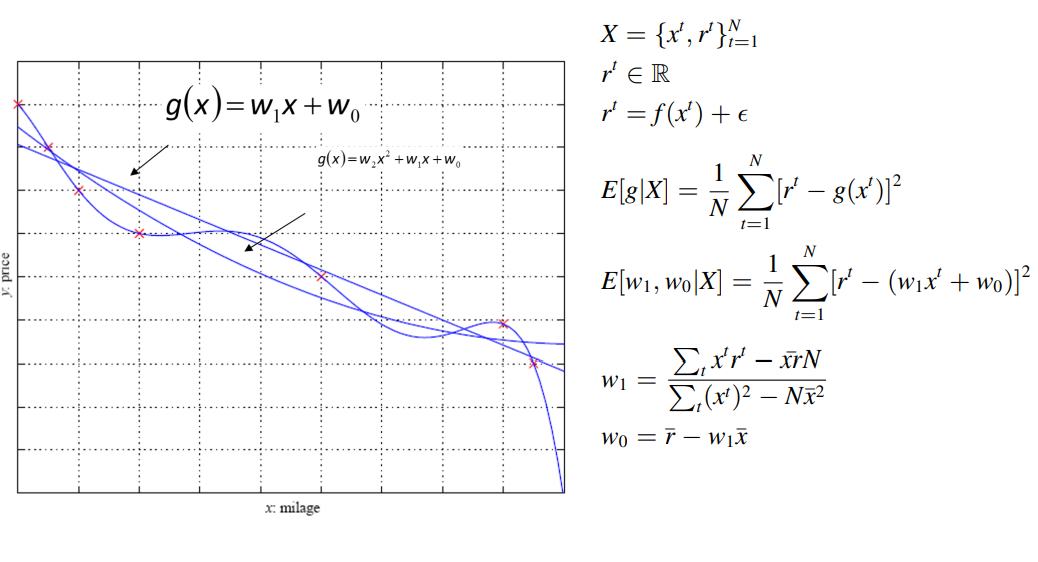

$\color{red}{\text{Question:}}$ Given a set of actual labels (gLabels) and predicted labels (gPredictedLabels), implement a function that returns RMSE

In [74]:
def getRMSE(glabels, gPredictedLabels):
    diffs_square = 0
    data_points = len(glabels)
    for i in range(data_points):
        diffs_square += (glabels[i] - gPredictedLabels[i])**2
    RMSE = (diffs_square/data_points)**1/2
    return RMSE

A function that generates data points according to the equation (r = mx + b + noise) where m=2.25, b = 6, and noise$\sim N(0,1.21)$

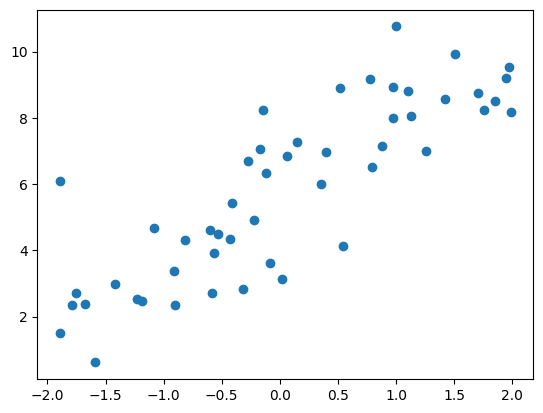

In [75]:
n_points = 50

b = 6 # intercept
m = 2.25 # slope
noise_mean = 0.0
noise_var = 1.21

X = []
r = []
for i in range(n_points):
    #rnd_num = random.random()
    rnd_num = np.random.uniform(-2, 2)
    X.append(rnd_num)
    r.append(b + m*rnd_num + np.random.normal(loc=noise_mean, scale=noise_var))
    #r.append(b + m *rnd_num)

plt.scatter(X, r, marker='o');

$\color{red}{\text{Question:}}$ Calculate $w_0$ and $w_1$ values in linear regression equation $r = w_0+w_1*x$ based on the closed form expressions in the lecture notes.

In [80]:
def cal_coefficents(x,r,n):
    w1, w2 = 0, 0
    x_mean = sum(x)/n
    r_mean = sum(r)/n
    x_r_sum = 0
    x_square = 0
    #w1 calculation
    for i in range(n):
        x_r_sum += x[i]*r[i]
    for i in range(n):
        x_square += x[i]**2
        
    nom = x_r_sum - (x_mean*r_mean*n)
    denom = x_square - (n*x_mean**2)
    
    w1 = nom/denom
    w0 = r_mean - w1 * x_mean
    return w0, w1

$\color{red}{\text{Question:}}$ Report the error with the calculated w_1 and w_0.

Hint: Use getRMSE() function that you have implemented

In [87]:
# Report the error with the calculated w_1 and w_0
w0, w1 = cal_coefficents(X, r, n_points)
print(f'calculated coefficients are: {w0, w1}')
predicted_list = []
for i in range(n_points):
    predicted = w0 + w1 * X[i]
    predicted_list.append(predicted)
RMSE = getRMSE(r, predicted_list)
print(f'RMSE from calculated coefficients functions is: {RMSE}')

calculated coefficients are: (5.745567352242767, 1.9452238472942072)
RMSE from calculated coefficients functions is: 0.9893651587045015


$\color{red}{\text{Question:}}$ Plot the data points along with the fitted line.

Hint: Use mathplotlib library's plot function

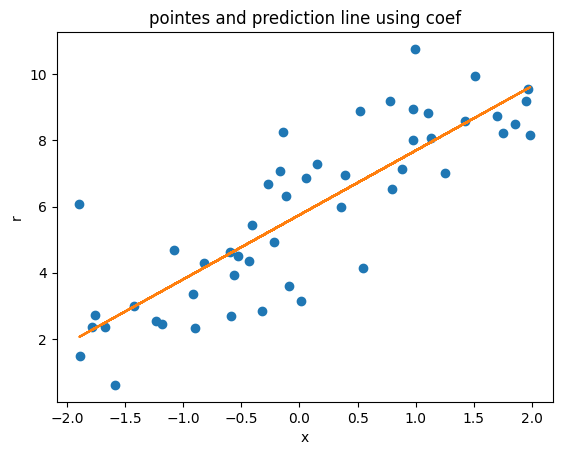

In [99]:
# Plot the data points along with the fitted line
plt.plot(X,r,'o')
plt.plot(X, predicted_list)
plt.xlabel('x')
plt.ylabel('r')
plt.title('pointes and prediction line using coef')
plt.show()

using library functions for linear regression

In [88]:
xx = np.array(X)
rr = np.array(r)

# transforming the data to include another axis
xx = xx[:, np.newaxis]
rr = rr[:, np.newaxis]

# sklearn linear regression function
model = LinearRegression()
model.fit(xx, rr)
r_pred = model.predict(xx)

# The coefficients + Intercept
print('Intercept: \n', model.intercept_)
print('Coefficients: \n', model.coef_)

RMSE = getRMSE(rr, r_pred)
print("RMSE",RMSE)

# insert codes for plotting the fitted function

Intercept: 
 [5.74556735]
Coefficients: 
 [[1.94522385]]
RMSE [0.98936516]


using library functions for polynomial regression

In [89]:
import operator
from sklearn.preprocessing import PolynomialFeatures

def polyFit(gxx, grr, gnDegree):

    polynomial_features= PolynomialFeatures(degree=gnDegree)
    x_poly = polynomial_features.fit_transform(gxx)

    model = LinearRegression()
    model.fit(x_poly, grr)
    r_poly_pred = model.predict(x_poly)

    # The coefficients + Intercept
    print('Intercept: \n', model.intercept_)
    print('Coefficients: \n', model.coef_)
    
    #RMSE = getRMSE(gxx, grr, r_poly_pred)
    #print('RMSE',RMSE)

    plt.scatter(gxx, grr, s=10)

    # sort the values of x before line plot
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(gxx,r_poly_pred), key=sort_axis)
    gxx, r_poly_pred = zip(*sorted_zip)
    plt.plot(gxx, r_poly_pred, color='m')
    plt.show()
    
    return model.intercept_, model.coef_

Intercept: 
 [5.7828806]
Coefficients: 
 [[ 0.          1.94899392 -0.02915008]]


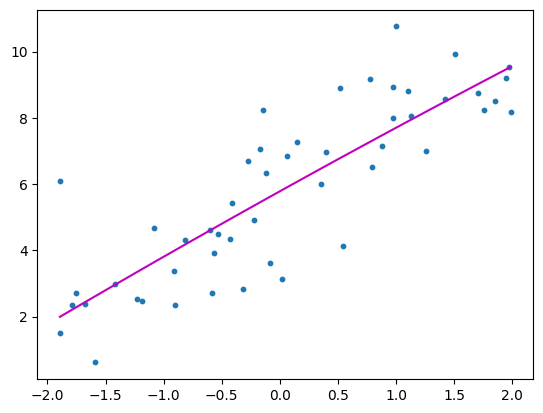

(array([5.7828806]), array([[ 0.        ,  1.94899392, -0.02915008]]))

In [90]:
xx = np.array(X)
rr = np.array(r)

# transforming the data to include another axis
xx = xx[:, np.newaxis]
rr = rr[:, np.newaxis]

polyFit(xx, rr, gnDegree=2)

Intercept: 
 [5.77213654]
Coefficients: 
 [[ 0.          2.90663795  0.00935964 -0.37469416]]


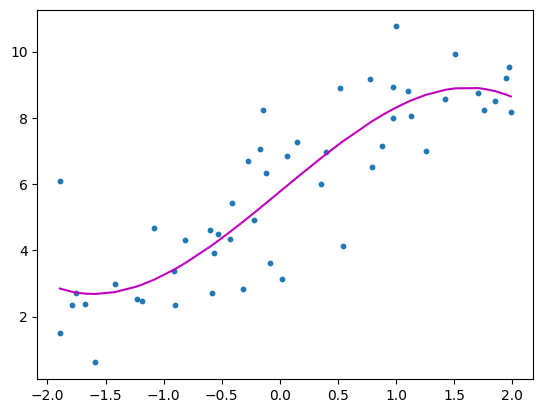

(array([5.77213654]),
 array([[ 0.        ,  2.90663795,  0.00935964, -0.37469416]]))

In [91]:
polyFit(xx, rr, gnDegree=3)

Intercept: 
 [5.74398976]
Coefficients: 
 [[ 0.          2.39264799  0.49550928  0.33292582 -0.61597182 -0.1740632
   0.14327291]]


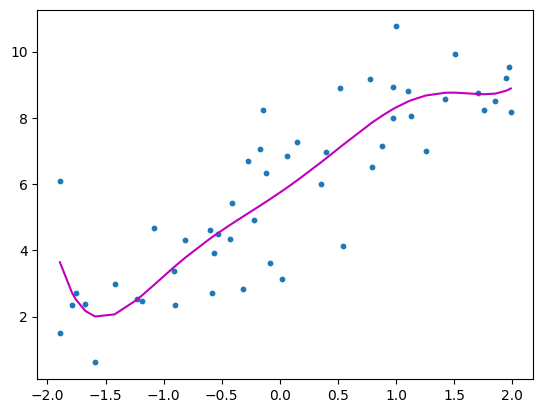

(array([5.74398976]),
 array([[ 0.        ,  2.39264799,  0.49550928,  0.33292582, -0.61597182,
         -0.1740632 ,  0.14327291]]))

In [92]:
polyFit(xx, rr, gnDegree=6)